# **Hic and RNA-seq Autoencoder**

# **Import libraries**

In [1]:
import keras
from keras import layers
import numpy as np
from keras.utils.vis_utils import plot_model
from keras.initializers import RandomNormal
import matplotlib.pyplot as plt
from keras.optimizers import Adam
import pandas as pd
import plotly.express as px
import plotly.graph_objects as go

# **Function that returns the Autoencoder, Encoder and Decoder models**


In [2]:
def generate_autoencoder(side_length,input_size_rnaseq,encoding_size):
    init = RandomNormal(stddev=0.02)

    input_rnaseq = keras.Input(shape=(input_size_rnaseq), name='input_rnaseq')
    encoded_rna_seq = layers.Dense(input_size_rnaseq, activation='relu', name='encoder_rnaseq',  kernel_initializer=init)(input_rnaseq)

    input_img = keras.Input(shape=(side_length,side_length,1), name='input_hic')
    conv_hic = layers.Conv2D(filters=2,kernel_size=(4,4),strides=(1,1), padding='same', activation='relu')(input_img)
    flat_hic = layers.Flatten()(conv_hic)

    concat = layers.Concatenate()([flat_hic, encoded_rna_seq])

    # this is the encoding layer
    encoded_nucleome = layers.Dense( encoding_size  , activation='relu', name='encoded_nucleome', kernel_initializer=init)(concat)

    decoder_rna = layers.Dense( input_size_rnaseq, activation='sigmoid', name='decoder_rna')(encoded_nucleome)
    decoder_rna = layers.Reshape((input_size_rnaseq,1))(decoder_rna)

    nucleome_nodes = side_length * side_length * 1
    decoder = layers.Dense( nucleome_nodes, name='decoder_layer')(encoded_nucleome)
    decoder = layers.LeakyReLU(alpha=0.1)(decoder)
    decoder_shaped_hic = layers.Reshape( (side_length, side_length ,1 ))(decoder)
    decoder_hic = layers.Conv2D(filters=1,kernel_size=(4,4),strides=(1,1), padding='same', activation='sigmoid')(decoder_shaped_hic)

    autoencoder = keras.Model( [input_img,input_rnaseq], [ decoder_hic, decoder_rna] , name='autoencoder')

    encoder =  keras.Model( [input_img,input_rnaseq], encoded_nucleome , name='encoder')

    input_decoder = keras.Input(shape=(encoding_size,), name='input_decoder')
    
    '''for index, layer in enumerate(autoencoder.layers):
        print(index,layer.name)'''
    
    # rna_decoder
    decb = autoencoder.layers[-3](input_decoder)
    decb = autoencoder.layers[-1](decb)

    # hic decoder
    decc = autoencoder.layers[-6](input_decoder)
    decc = autoencoder.layers[-5](decc)
    decc = autoencoder.layers[-4](decc)
    decc = autoencoder.layers[-2](decc)

    decoder = keras.Model( input_decoder, [ decc,decb ], name='decoder')

    return autoencoder, encoder, decoder

# **get the dataset**

In [3]:
!wget https://gitlab.com/jazberna/nucleome/-/raw/master/dataset/hic_rnaseq_chr1_100.zerotoone.npz

--2020-12-06 17:40:48--  https://gitlab.com/jazberna/nucleome/-/raw/master/dataset/hic_rnaseq_chr1_100.zerotoone.npz
Resolving gitlab.com (gitlab.com)... 172.65.251.78, 2606:4700:90:0:f22e:fbec:5bed:a9b9
Connecting to gitlab.com (gitlab.com)|172.65.251.78|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 152210 (149K) [application/zip]
Saving to: ‘hic_rnaseq_chr1_100.zerotoone.npz’

hic_rnaseq_chr1_100 100%[===================>] 148.64K  --.-KB/s    in 0.01s   

2020-12-06 17:40:48 (10.1 MB/s) - ‘hic_rnaseq_chr1_100.zerotoone.npz’ saved [152210/152210]



In [4]:
dataset = np.load('hic_rnaseq_chr1_100.zerotoone.npz')

The dataset contains two numpy arrays, 'hic' and 'rna_seq'. Both arrays contain 19 arrays. In the case of the 'hic' the arrays are 100x100x1 chr 1 HiC contact matrices. In the case of 'rna_seq' the arrays are 100x1 chr 1 transcript count bins. There are four arrays (technical replicates) for each exposure time to dexamethasone whith the exception of 1 hour exposure for which there are only three replicates. These are the time corresponding indexes for both the 'hic' and 'rna_seq' arrays d arrays:

- Indexes 0 to 3
Hi-C on A549 cell line treated with 100 nM dexamethasone for 0 hours.

- Indexes 4 to 6
Hi-C on A549 cell line treated with 100 nM dexamethasone for 1 hours.

- Indexes 7 to 10
Hi-C on A549 cell line treated with 100 nM dexamethasone for 4 hours.

- Indexes 11 to 14
Hi-C on A549 cell line treated with 100 nM dexamethasone for 8 hours.

- Indexes 15 to 18
Hi-C on A549 cell line treated with 100 nM dexamethasone for 12 hours.

# **These variables set the dimensions of the HiC contact matrix (side_length x side_length x 1), the transcript count chromosome bins (input_size_rnaseq x 1) and the embedding size (encoding_size).**


In [5]:
side_length=100
input_size_rnaseq = 100
encoding_size = 300

# **Generate the models and the optimizer, then compile the model and fit it**

In [6]:
autoencoder, encoder, decoder = generate_autoencoder(side_length,input_size_rnaseq,encoding_size)

In [7]:
opt = Adam(lr=0.0002,beta_1=0.5)

In [8]:
autoencoder.compile(loss=['mean_squared_error','mean_squared_error'], optimizer=opt)

In [ ]:
autoencoder.fit( [dataset['hic'] , dataset['rna_seq'] ], [ dataset['hic'], dataset['rna_seq'] ],
                     epochs=500,
                     batch_size=19,
                     shuffle=True)

# **Show how well the model recovers the original HiC and RNA-seq data, top plots are real and bottom ones are predicted**

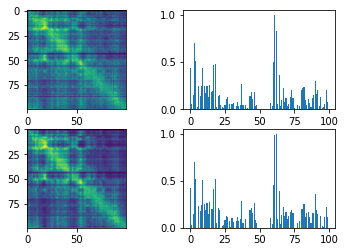

In [39]:
#REAL
plt.subplot(2,2,1)
plt.imshow(np.reshape( dataset['hic'][0],(100,100)))

plt.subplot(2,2,2)
plt.bar( list(range(0,100)) ,np.reshape(dataset['rna_seq'][0],(100)))

#PREDICTED
predicted = autoencoder.predict([dataset['hic'] , dataset['rna_seq'] ])
plt.subplot(2,2,3)
plt.imshow(np.reshape(predicted[0][0],(100,100)))

plt.subplot(2,2,4)
plt.bar( list(range(0,100)) ,np.reshape(predicted[1][0],(100)))

plt.show()

# **Now display the HiC contact map for time zero hours of drug exposure**

In [45]:

x,y,z=list(),list(),list()
for i in range(0,predicted[0][0].shape[0]):
    for j in range(0,predicted[0][0].shape[0]):
        x.append(i)
        y.append(j)
        z.append(predicted[0][0][i,j][0])

#z = np.array((z * 2)) - 1
df = pd.DataFrame(list(zip(x, y, z)),columns =['X', 'Y', 'Z'])
fig = px.scatter_3d(df, x='X', y='Y', z='Z',color='Z',opacity=0.3, range_x=(0,max(x)), range_y=(0,max(y)), range_z=(-1,1))
fig.show()

# **Now display the HiC contact map for time 12 hours of drug exposure**

In [46]:
x,y,z=list(),list(),list()
for i in range(0,predicted[0][18].shape[0]):
    for j in range(0,predicted[0][18].shape[0]):
        x.append(i)
        y.append(j)
        z.append(predicted[0][18][i,j][0])
#z = np.array((z * 2)) - 1
df = pd.DataFrame(list(zip(x, y, z)),columns =['X', 'Y', 'Z'])
fig = px.scatter_3d(df, x='X', y='Y', z='Z',color='Z',opacity=0.3, range_x=(0,max(x)), range_y=(0,max(y)), range_z=(-1,1))
fig.show()

# **Now display the error differential HiC subtracting the embedding of zero hours to the one at twelve hours of drug exposure, also center on the mean**

In [49]:


econded_0 = encoder.predict( [ dataset['hic'][0].reshape((1,100,100,1)) , dataset['rna_seq'][0].reshape((1,100,1))]   )
econded_12 = encoder.predict( [ dataset['hic'][18].reshape((1,100,100,1)) , dataset['rna_seq'][18].reshape((1,100,1))]   )
hic_dif=econded_12 - econded_0 
hic_diff_decoded, rna_seq_diff_decoded = decoder.predict(hic_dif)

x,y,z=list(),list(),list()
for i in range(0,hic_diff_decoded.shape[1]):
    for j in range(0,hic_diff_decoded.shape[1]):
        x.append(i)
        y.append(j)
        z.append(hic_diff_decoded[0][i,j][0])
z = np.array(z - np.mean(z))
df = pd.DataFrame(list(zip(x, y, z)),columns =['X', 'Y', 'Z'])
fig = px.scatter_3d(df, x='X', y='Y', z='Z',color='Z',opacity=0.3, range_x=(0,max(x)), range_y=(0,max(y)), range_z=(-1,1))
fig.show()

# **Now perform differential RNA-seq subtracting the embedding of zero hours to the one at twelve hours of drug exposure**

In [43]:
rna_seq_diff_decoded= rna_seq_diff_decoded.reshape((100))
rna_seq_diff_decoded = np.array((rna_seq_diff_decoded * 2)) - 1
df_rnaseq = pd.DataFrame(list(zip( range(0,rna_seq_diff_decoded.shape[0]), rna_seq_diff_decoded  )),columns =['chr_1_bins', 'differential_expression'])
fig1 = px.bar(df_rnaseq, x='chr_1_bins', y='differential_expression', color='differential_expression')
fig1.show()